# Going Deeper 06
## 프로젝트 : End-to-End OCR

### 프로젝트 구성
1. Recognition model
    - (1) Recognition model
    - (2) Input Image
    - (3) Encode
    - (4) Build CRNN model
    - (5) Train & Inference
2. 프로젝트 : End-to-End OCR
3. 결과 정리

### 프로젝트 목표
1. Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행
    - 텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치 처리 수행
2. CRNN 기반의 recognition 모델의 학습이 정상적으로 진행
    - 학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과를 정확하게 인식
3. keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성
    - 샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어짐

In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


# Recognition model (1)

Recognition model은 2015년에 발표된 CRNN 구조를 활용해서 만들 예정입니다.

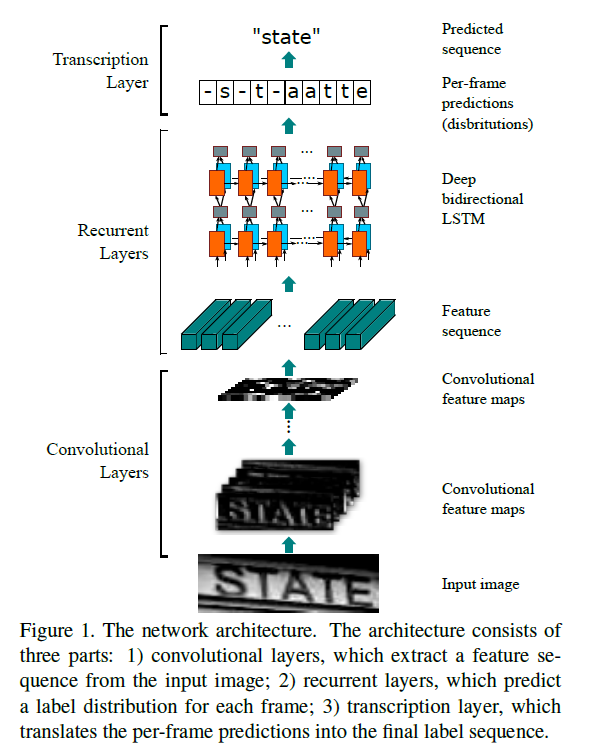
출처: [해당 논문](https://arxiv.org/pdf/1507.05717.pdf)

CRNN의 구조를 살펴보기 위해 아래 Input image부터 보면 됩니다. 입력 이미지를 Conv layer를 통해 Feature를 추출하여 feature를 얻어냅니다.

Recurrent Layers는 추출된 feature의 전체 context를 파악하고 다양한 output 크기에 대응이 가능합니다.

마지막으로 Transcription layer(Fully connected layer)는 step마다 어떤 character의 확률이 높은지 예측합니다.

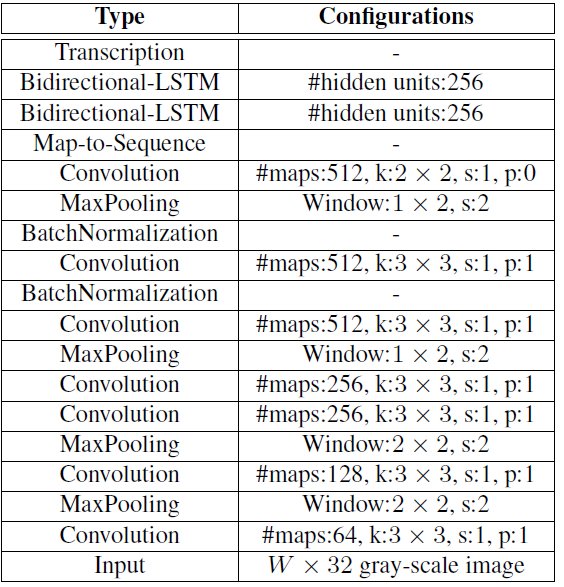

전체 구조는 위와 같습니다.

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


lmdb를 이용할 예정입니다. LMDB는 Symas에서 만든 Lightning Memory-Mapped Database의 약자이며, 다루게 될 dataset이 lmdb 포맷(mdb) 파일로 이루어져 있습니다.

In [3]:
# 설치 명령어 (다운로드 필요시 주석 해제 후 사용)
# pip install lmdb

In [20]:
# 필요한 라이브러리 import

import re
import six
import math
import lmdb
import copy
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


# Recognition model (2) Input Image

dataset에 있는 image가 실제로 어떻게 생겼는지 확인해보겠습니다. 아래 코드를 실행해 lmdb를 통해 train dataset의 이미지를 4개만 열어 실제 shape, label을 확인해보겠습니다.

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


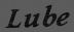

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


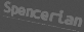

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


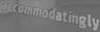

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


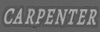

In [5]:
from IPython.display import display

# env에 데이터를 불러옴
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는 것이 일반적

env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이란 변수를 통해 엽니다
# 이제 txn 변수를 통해 직접 데이터에 접근 가능

with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어옴
        # 버퍼에서 이미지로 변환하는 과정 필요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿈
        # 너비는 100보다 작게 유지
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 image와 label 함께 출력     
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

대부분의 이미지는 최대 32까지의 height를 가지고 있고, width는 문자열 길이에 따라 다르게 나타납니다.

이제 lmdb를 활용하여 keras model 학습용 MJStnth dataset의 class를 구현하려고 합니다.

- `dataset_path`는 읽어들일 데이터셋의 경로입니다.
- `label_converter`는 아래에서 문자를 미리 정의된 index로 변환해주는 converter로 직접 구현할 예정입니다.
- `batch_size`와 Input image 크기, 필터링을 위한 최대 글자 수, 학습 대상으로 한정하기 위한 character 등을 입력으로 받도록 구현 되어 있음

In [6]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비
    # lmdb에 있는 데이터 수를 미리 파악
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다.
    # 위에서 사용한 코드와 매우 유사
    # label을 조금 더 다듬는 것이 다름
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__ 은 약속되어 있는 메서드임
    # 이 부분을 작성하면 slice 할 수 있음
    # 자세한 내용 아래 문서 참고
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    #
    # 1. idx에 해당하는 index_list만큼 데이터를 불러옴
    # 2. image와 label을 불러옴
    # 3. 사용하기 좋은 inputs과 outputs 형태로 반환함
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

위 분석코드처럼 이미지 데이터를 img, label의 쌍으로 가져오는 부분은 `_get_img_label()` 메소드에 반영됨. `model.fit()`에서 호출되는 `__getitem__()` 메소드에서 배치 단위만큼 `_get_img_label()`을 통해 가져온 dataset을 return함. `_get_img_label()`을 보면 다양한 사이즈의 이미지를 모두 height는 32로 맞추고, width는 최대 100까지 맞춤

# Recognition model (3) Encode

이전 데이터를 확인해 보았을 때, label이 읽을 수 있는 평문 text로 이루어져 있었음. 그러나 이것은 모델을 학습하기 위해 적절한 형태가 아님. 따라서 각 character을 class를 생각하고 이를 step에 따른 class index로 변환해서 encode를 해주어야 함. 이를 해줄 수 있는 `LabelConverter` 클래스를 작성.

- __init__()에서는 입력으로 받은 text를 `self.dict`에 각 charactter들이 어떤 index에 매핑되는지 저장. 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어짐. 만약 character = 'ABCD'라면 `'A'`의 label은 1, `'B'`의 label은 2가 됨.
- 공백(blank) 문자를 지정. 여기서는 공백 문자를 `'-'`을 활용하여 표현, label은 0으로 지정
- decode()는 각 index를 다시 character로 변환한 후 이어주어 읽을 수 있는 text로 바꾸어줌

> 입력 받은 text를 모델이 학습할 수 있는 label로 만드는 encode() 메소드를 구현해야 함. 단, 같은 글자가 연속으로 이어지는 경우 이어지는 그 사이에 공백 문자의 label을 포함해야 함

In [7]:
class LabelConverter(object):
    
    def __init__(self, character):
        self.character="-" + character
        self.label_map = dict()
        
        for i, char in enumerate(self.character):
            self.label_map[char]=i
            
    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i-1]:
                encoded_label.append(0) # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])    
        return np.array(encoded_label)
    
    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label
    
print("슝💨")

슝💨


In [8]:
# 'HELLO'를 Encode한 후 Decode가 정상적으로 되는지 확인하기
label_converter = LabelConverter(TARGET_CHARACTERS)

encoded_text = label_converter.encode('HELLO')
print('Encoded_text:', encoded_text)
decoded_text = label_converter.decode(encoded_text)
print('Decoded_text:', decoded_text)

Encoded_text: [ 8  5 12  0 12 15]
Decoded_text: HEL-LO


동일한 글자 'L'이 연속될 때, 그 사이에 공백 문자가 포함된 것을 확인할 수 있음

# Recognition model (4) Build CRNN model

입력과 출력을 준비했으니 모델을 만들겠습니다. Keras에서 제공하는 k.ctc_batch_cost()를 활용해서 losff를 계산하도록 `ctc_lambda_func`를 아래와 같이 만들어두었습니다.

In [9]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

print("슝💨")

슝💨


`K.ctc_batch_cost()`는 keras의 함수입니다. CTC Loss 함수를 구현하기 위해 어떤 값을 인자로 받아야 하는지 보겠습니다.

- 참고 자료: [Tensorflow Tutorial - ctc_batch_cost](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/backend/ctc_batch_cost)

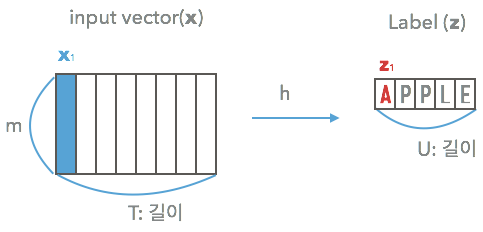

CTC Loss는 위 그림과 같은 상황을 다룹니다. 입력의 길이 T와 라벨의 길이 U와 일치하지 않을 때, label은 `APPLE`이지만 모델이 출력한 결과는 `AAAPPPPLLLLEE`처럼 나올 수 있음. 이 상황이 이미지에서 텍스트 라벨을 추론해야 하는 Text recognition task에 동일하게 적용됨

> 만약 모델이 AAAPPPPLLLLEE을 출력했다면, 이때 추론 결과는 APLE일지 APPLE일지 구분 불가능 -> 이 경우에는 APLE로 결론을 내리게 됨

> 그러므로 추론 결과가 APPLE이 되게 하려면 이미지의 라벨은 AP-PLE로 보정해 주어야 함. 그래서 모델이 AAAPP-PPLLLEE로 출력을 한다면 추론 결과는 APPLE이 됨. 이 이유로 이전 스텝에서 LabelConverter.encode() 메소드에 공백문자 처리 로직을 포함했었음


위 텐서플로우 튜토리얼에 따르면, `K.ctc_batch_cost(y_true, y_pred, input_length, label_length)`에는 4가지 인자가 존재함.

- `y_true`: tensor (samples, max_string_length) containing the truth labels.
- `y_pred`: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
- `input_length tensor`: (samples, 1) containing the sequence length for each batch item in y_pred.
- `label_length tensor`: (samples, 1) containing the sequence length for each batch item in y_true.

(여기서 samples는 배치사이즈를 의미함)

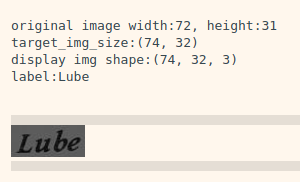

위 그림은 이전에 살펴본 dataset의 sample임. 이 케이스를 예로 들면 인자는

- `y_true`: 실제 라벨 `LUBE`. 텍스트 라벨 그대로가 아니라 각 글자를 one-hot encoding한 형태. max_string_length 값은 모델에서 22로 지정
- `y_pred`: RCNN `모델의 출력 결과`. 길이는 4가 아니라 RNN의 최종 출력 길이로서 24가 될 예정
- `input_length tensor`: 모델 입력 길이 T로서, 텍스트의 width인 `74`
- `label_length tensor`: label의 실제 정답 길이 U로서, `4`가 됨

In [10]:
# K.ctc_batch_cost()를 활용하여
# image_input을 입력, 마지막 Label을 'output'으로 출력하는 layer를 갖도록
# 모델을 만드는 함수 build_crnn_model()을 구현


def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

print("슝💨")

슝💨


# Recognition model (5) Train & Inference

In [11]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [12]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=100,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])

Epoch 1/100
565/565 [==============================] - 183s 283ms/step - loss: 27.5233 - val_loss: 23.7420

Epoch 00001: val_loss improved from inf to 23.74205, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/100
565/565 [==============================] - 156s 277ms/step - loss: 18.9328 - val_loss: 9.1653

Epoch 00002: val_loss improved from 23.74205 to 9.16527, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/100
565/565 [==============================] - 157s 278ms/step - loss: 7.9014 - val_loss: 6.4984

Epoch 00003: val_loss improved from 9.16527 to 6.49842, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/100
565/565 [==============================] - 157s 278ms/step - loss: 5.3701 - val_loss: 5.3359

Epoch 00004: val_loss improved from 6.49842 to 5.33590, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/100
565/565 [==============================] - 158s 279ms/step - loss: 4.1815 - val_loss: 5.1199

Epoch 00005: val_

In [13]:
# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING9999999999999999


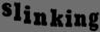

Result: 	 ALEPPO99999999999999999


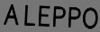

Result: 	 RWONDA999999999999999999


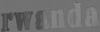

Result: 	 NATHANS99999999999999999


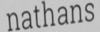

Result: 	 HALLO999999999999999999


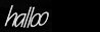

Result: 	 HUERLS999999999999999999


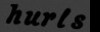

Result: 	 DOWNSIZE9999999999999999


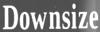

Result: 	 ROBOTIC99999999999999999


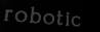

Result: 	 STOPPY99999999999999999


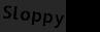

Result: 	 HERMITE99999999999999999


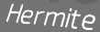

In [14]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

# 프로젝트: End-to-End OCR

- `detect_text`: 이미지 경로를 받아 해당 이미지 내의 문자를 찾아내는 함수 `detect_text`를 keras-ocr의 Detector를 이용해서 만듦
- `inference`한 후, 시각화하여 단어의 영역을 자를 수 있도록 함

In [27]:
import cv2
import matplotlib.pyplot as plt
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = os.path.join(HOME_DIR+'/data/', 'sample.jpg')

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [35]:
def detect_text(img_path):
    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    # 배치의 첫 번째 결과만 가져옵니다.
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    img = cv2.imread(img_path)
    line_img = img.copy()
    input_img = img[tf.newaxis,...]
    result = detector.detect(input_img)
    ocr_result = result[0]
    
    cropped_imgs = []
    for text_result in ocr_result:
        for i in range(4):
            if i==3:
                line_img = cv2.line(line_img,tuple(text_result[3]),tuple(text_result[0]),(0,0,255),10)
            else:
                line_img = cv2.line(line_img,tuple(text_result[i]),tuple(text_result[i+1]),(0,0,255),10)
        
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        cropped_imgs.append(img[int(y_min):int(y_max),int(x_min):int(x_max)])
    
    return line_img, cropped_imgs

In [36]:
def recognize_img(input_img, input_img_size=(100,32)):
    # 잘려진 단어 이미지를 인식하는 코드
    img = input_img[:,:,::-1]
    img = cv2.resize(img, input_img_size)
    result_img = img.copy()
    img = img.transpose(1,0,2)
    img = img[tf.newaxis,...]
    output = model_pred.predict(img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(result_img.astype(np.uint8)))

In [37]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

array([[[209, 214, 213],
        [206, 211, 210],
        [202, 207, 206],
        ...,
        [178, 182, 187],
        [178, 182, 187],
        [181, 185, 190]],

       [[184, 189, 188],
        [183, 188, 187],
        [181, 186, 185],
        ...,
        [178, 182, 187],
        [177, 181, 186],
        [178, 182, 187]],

       [[171, 176, 175],
        [171, 176, 175],
        [172, 177, 176],
        ...,
        [179, 183, 188],
        [180, 184, 189],
        [183, 187, 192]],

       ...,

       [[103,  77,  60],
        [105,  79,  62],
        [106,  80,  63],
        ...,
        [101,  73,  56],
        [102,  74,  57],
        [102,  74,  57]],

       [[104,  78,  61],
        [105,  79,  62],
        [107,  81,  64],
        ...,
        [102,  74,  57],
        [103,  75,  58],
        [103,  75,  58]],

       [[103,  77,  60],
        [105,  79,  62],
        [107,  81,  64],
        ...,
        [102,  74,  57],
        [103,  75,  58],
        [104,  76,  59]]

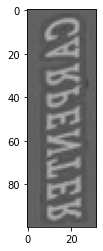

In [38]:
plt.imshow(img[:,:,::-1])

In [39]:
def recognize_img(input_img, input_img_size=(100,32)):
    # 잘려진 단어 이미지를 인식하는 코드
    img = input_img[:,:,::-1]
    img = cv2.resize(img, input_img_size)
    result_img = img.copy()
    img = img.transpose(1,0,2)
    img = img[tf.newaxis,...]
    output = model_pred.predict(img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(result_img.astype(np.uint8)))

Result: 	 REREIN99999999999999999


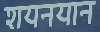

Result: 	 SLEEPER9999999999999999


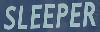

In [40]:
for _img in cropped_img:
    recognize_img(_img)

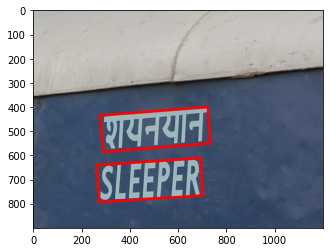

In [46]:
SAMPLE_IMG_PATH = os.path.join(HOME_DIR+'/data/', 'sample.jpg')
img, cropped_img = detect_text(SAMPLE_IMG_PATH)
plt.imshow(img[:,:,::-1])

Result: 	 REREIN99999999999999999


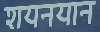

Result: 	 SLEEPER9999999999999999


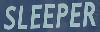

In [44]:
for _img in cropped_img:
    recognize_img(_img)

# 프로젝트 정리
- 모델 추론 결과를 확인해보니 영어는 대부분 정확하게 인식되었음
- 'sample1' 테스트 결과, text detection과 recognition이 잘 되었음
- 각도가 변경된 이미지의 경우 text detection은 잘 되지만 recognition이 잘 안 되는 결과를 볼 수 있었음
- 문자 뒤에 나오는 공백이 `9999999...`로 나오는 문제점을 해결하지 못함